**Google Data Analysis Capstone Project**

#**1. Ask**

**Project Description**

Goal: Design marketing strategies aimed at converting casual riders into annual members

Overall Strategy: how annual members and casual riders differ, why casual riders would buy a membership, and how digital media could affect their marketing tactics.

**Assignment to the Analyst**

Business Task: How do annual members and casual riders use Cyclistic bikes differently?

The research will focus on identifying any insights on seasonal behavior, station preferences, time dependence and other relations among the causal and member cyclists.

Objective: Assess if there are similarities or differences between annual members and casual riders on utilization of bikes based on days of week, months of last 12 years, ride routes, bike types, ride length


#**2. Data Preparation**

Data Source

The last 12 monthly trip data (November 2021 – October 2022) are downloaded from an archive site: Index of bucket "divvy-tripdata"(https://divvy-tripdata.s3.amazonaws.com/index.html). The data has been made available by Motivate International Inc.

The monthly data is organized in zip format and contains a file in comma-separated values(csv) format which encompasses a record of cyclists traveling from a given point to a destination station. It records start and end stations, star and end time, rideable type, location of stations, and membership status information. All datasets have the same structure.The data downloaded from the site and combined using R format using the following steps:

Monthly cyclist trip data is downloaded in zip format and stroed on the project folder (C:\project\_biketrip). The following code chucks do:

-   changes the working directory to the project folder, and
-   unzip all downloaded files and store it to data subfolder.

```{r}
#Add required libraries
library(tidyverse)
library(lubridate)

```

```{r}
#set project directory as working directory

setwd("C:\\Project_biketrip")

#read and put the working directory in a variable
working_directory<-getwd()

#read all downloaded files in data foloer of a project directory
data_list <- list.files(path='./data', pattern='.zip', all.files=TRUE,
    full.names=TRUE)

#unzip all monthly zip files and store the csv files
for (zip_file in data_list){
  unzip(zip_file, files = NULL, list = FALSE, overwrite = TRUE,
      junkpaths = FALSE, exdir = "./data", unzip = "internal",
      setTimes = FALSE)
}
```
____________________________________________________________________________________

Data Exploration
Monthly data was explored for null values/missing values

```{r}
all_csv_data <- list.files(path='./data', pattern='.csv', all.files=TRUE,
    full.names=TRUE)

#create a dataframe for each month that holds null values information for each column
result_count_obv_not_null<-data.frame(month_='', count_not_null='')
i<-1
for (month in all_csv_data){
  mon <- paste("Month-",i)
  tbl<- data.frame(read_csv(month))
  
  #all observation without null values in current month
  not_na <- tbl[complete.cases(tbl), ]
  #add the value to the data frame
  result_count_obv_not_null <- rbind(result_count_obv_not_null, c(mon, nrow(not_na)))
  
  #data frame to hold the total count of null values in each table
  result<-data.frame(total_observation='', col_name='', count_null='')
  
  #check for null values in each column and add a record of column name and total null values in a result dataframe
  for (col in colnames(tbl)){
    result <-rbind(result, c(nrow(tbl),col, sum(is.na(tbl[col]))))
  }
  
  #creae a csv file for each month 
  write.csv(result, paste('./out/',mon,'.csv'))
  
  i<-i+1
}
write.csv(result_count_obv_not_null,'./out/observation_alldata_non_value_count.csv')
```

The result csv file displayed number of null values in each month. 

___________________________________________________________________________________________
Filter and Sort - explore first month data

```{r}
#read a single month data (november 2021)
month1_data = read_csv("./data/202111-divvy-tripdata.csv")

#all data with station_name and group by rideable_type and member_casual

month1_data %>% 
  filter(start_station_name !='') %>% 
  group_by(rideable_type, member_casual) %>% 
  summarise(count=n())


# all data without null value and groped by member_calual
month1_no_na <- month1_data[complete.cases(month1_data), ]
month1_no_na %>%
    group_by(member_casual) %>% 
    summarise(count=n())
```    
 


#**3- Data Processing**

##**Combine Datasets**

At this stage, details will be explored about the data. All data will be combined to a single file. the csv files in the last stage will be combined using the following r code chunks.

```{r}
all_csv_data <- list.files(path='./data', pattern='tripdata.csv', all.files=TRUE,
    full.names=TRUE) %>% 
  lapply(read_csv) %>% 
  bind_rows

#Save the raw data in case we need unedited data (orignial file) without data manipulation 
write.csv(all_csv_data,file="./data/all_raw_biketrip.csv")
```
Total number of observation
```{r}
#check number of observation: original data
nrow(all_csv_data)

#remove missing observations with missing values
biketrip_no_missing <- all_csv_data[complete.cases(all_csv_data), ]
```
Total observation was 5755694 and after removing the null values it becomes 4410438


##**Missing and duplicate values**
```{r}
#check for duplicated values
sum(duplicated(biketrip_no_missing))
```
The result shows there is no duplicate value

**Convert Data Types**

Convert the started_at  and ended_at to datetime format
```{r}
# convert the started_at and ended_at columns to date and time format

biketrip_no_missing$started_at<-as_datetime(biketrip_no_missing$started_at, format="%Y-%m-%d %H:%M:%S")
biketrip_no_missing$ended_at <- as_datetime(biketrip_no_missing$ended_at, format="%Y-%m-%d %H:%M:%S")
```
##**Data Transformation**

Ride Lenght
Calculate the duration (ride_length) of the each trip started at and end at times.

```{r}
library(hms)
biketrip_no_missing <- biketrip_no_missing %>% 
  mutate(ride_length_ss = round(difftime(ended_at,started_at),0)) %>% 
  mutate(ride_length = hms(as.numeric(difftime(ended_at,started_at)))) %>% 
  arrange(desc(ride_length))
```

Date Dimensions: the started_at column was used to calculate the following time dimensions:
•	the day of week as 1 to 7, Sunday is considered as the first day and Saturday as last day.
•	The year column as yyyy
•	The month_of_year column as number m
•	The year_month format ‘yyyy-mm’

```{r}
#Calculate days of weeks, months of years, year, and month_year from start_at field
biketrip_no_missing<- biketrip_no_missing %>% 
  mutate(day_of_week = wday(started_at, abbr = TRUE, week_start = 7)) %>% 
  mutate(month_of_year= month(started_at, label = FALSE, abbr = TRUE)) %>% 
  mutate(year = year(started_at)) %>% 
  mutate(mon_year=format(started_at,"%Y-%m"))
```

Remove Negative ride length, create new column, route, form start an end station names
```{r}
#check for negative or zero ride length
nrow(biketrip_no_missing %>% 
  filter(ride_length_ss<=0))#295 observations 

#remove negative or zero (seconds) ride length 
biketrip_no_missing<-biketrip_no_missing %>% 
  filter(ride_length_ss>0)

#Create a new column with name route that combines start and end stations
data_bike<- data_bike %>% mutate(route = paste(start_station_name," - ",end_station_name))
```
Rides with high ride length?
I noted some ride length shows a long time span between start and end time. I filtered top 100 observations with high ride length data and try to study the data. This is a kind of request that has to be made to the stakehoders and discuss among the team. There might be a reason why travel time may take days instead of minutes or hours (may be they rent it for long period? Error with the data entry?). For examples, 13 observations with end sation name "Base - 2132 W Hubbard Warehouse" are among the highest ride length. 

```{r}
#trips with high ride length
high_ride_length <- head(data_bike %>% 
       arrange(desc(ride_length_ss)),100)
```
I tried to evaluate the data in general. For example the follwoing code evaluated the overall mean and the mean of by user type before and after removing ride length with more than a days (86400 seconds).

```{r}
#compare the mean with or without high ride_length
less_than_aday<- data_bike %>% 
  filter(ride_length_ss<=86400) #220 observation removed
  
print(mean(data_bike$ride_length_ss)) # all observation 1034.509 secs - the difference is about 8 seconds 

print(mean(less_than_aday$ride_length_ss))# filtered observation 1022.324 secs



#mean difference by user type
data_all <- data_bike %>% 
        group_by(member_casual) %>% 
        summarise(mean=mean(ride_length_ss)) # mean of casual 1463 and members 747.19 seconds
        
data_filter <- less_than_aday %>% 
        group_by(member_casual) %>% 
        summarise(mean=mean(ride_length_ss)) # mean of casual 1434.5842 and members 746.47 seconds. Note that about 30 second difference among casual category
```

Technically, the data is clean but such logical quetions must be resolved before doing the analysis. Since this is a project, I will proceed with the analysis, however, definitely this will affect the outcomes when we deal with specific (smaller) group and needs data verfication.

```{r}
#save the file 
write.csv(data_bike, './out/tripdata_nov21_oct22_clean.csv')
```

#**4- Data Analysis**

Now the data is clean ready for analysis and added to the dataset. The analysis can be done from kaggle.
The Analysis stage intend to find some insights to answer the business task. outputs of each analysis, visualizations, will be saved as png pictures and used during data sharing process.

In [1]:
#add the required libraries
library(tidyverse)
library(lubridate)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
#Read the file from the project data folder
data_biketrips<-read.csv('../input/google-projectbiketrip/tripdata_nov21_oct22_clean.csv')

Saving 12.5 x 6.67 in image



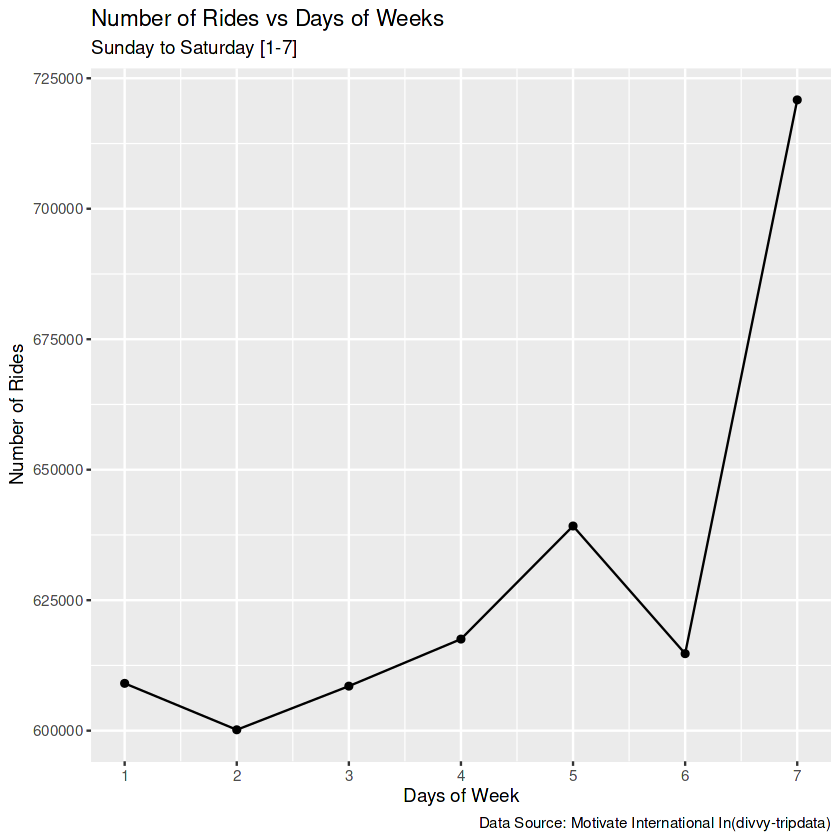

In [3]:
#summarize the data by number of Rides vs Day of Weeks and plot it
buzy_day<- data_biketrips %>% 
  group_by(day_of_week) %>% 
  summarise(count=n())

#str(data_biketrips)
ggplot(data=buzy_day, aes(x=day_of_week, y=count) )+
  geom_line()+
  geom_point()+
  labs(x="Days of Week", y="Number of Rides", title="Number of Rides vs Days of Weeks", subtitle = "Sunday to Saturday [1-7]", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_x_continuous(breaks=c(1:7), labels=c(1:7),limits=c(1,7))
ggsave("rides_by_days_of_week.png")

Insight 1: If we combine both user types (casual and members), the result indicates Saturday is the pick day with largest number of bike riders. Thirsday is the second day of week, and Monday is with the least riders on the road.

Saving 12.5 x 6.67 in image



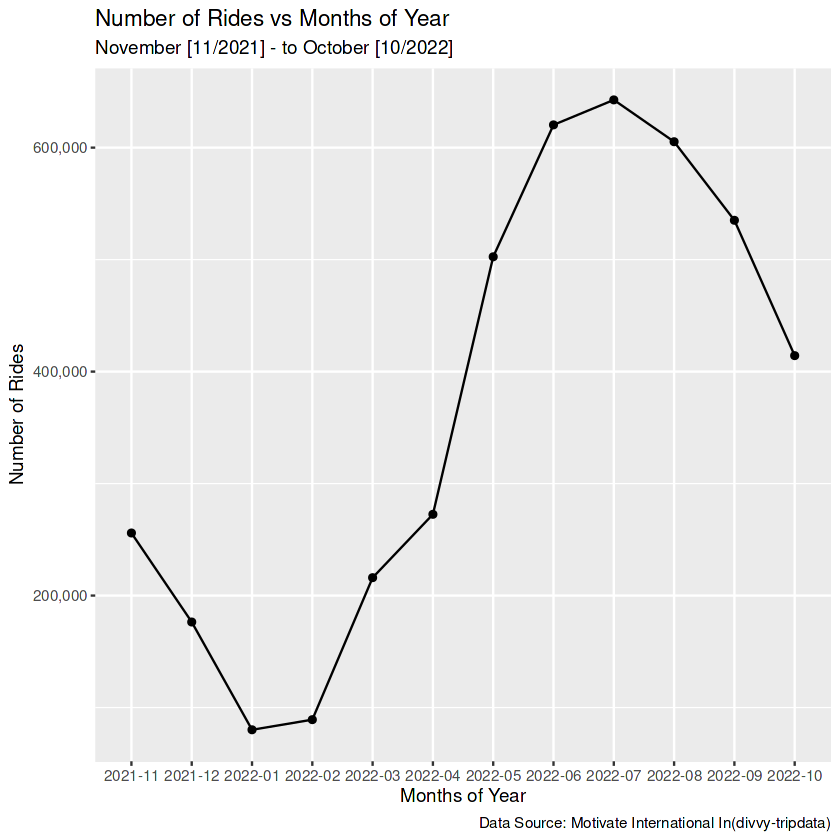

In [4]:
#Number of Rides vs Month of Year
buzy_month<- data_biketrips %>% 
  group_by(mon_year) %>% 
  dplyr::summarise(count=n())


ggplot(data=buzy_month, aes(x=mon_year, y=count, group=1))+
  geom_line()+
  geom_point()+
  labs(x="Months of Year", y="Number of Rides", title="Number of Rides vs Months of Year", subtitle = "November [11/2021] - to October [10/2022]", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_y_continuous(labels = label_comma())
ggsave("2_rides_by_months_of_year.png")

Insight 2: Riders number is lowest in January 2022 and highst in August. The number of bike riders on the road during May to October wiht high in number compared to other months in the last twelve months.

member_casual,mean,count
<chr>,<dbl>,<int>
casual,1464,1768046
member,747,2642097


Saving 12.5 x 6.67 in image



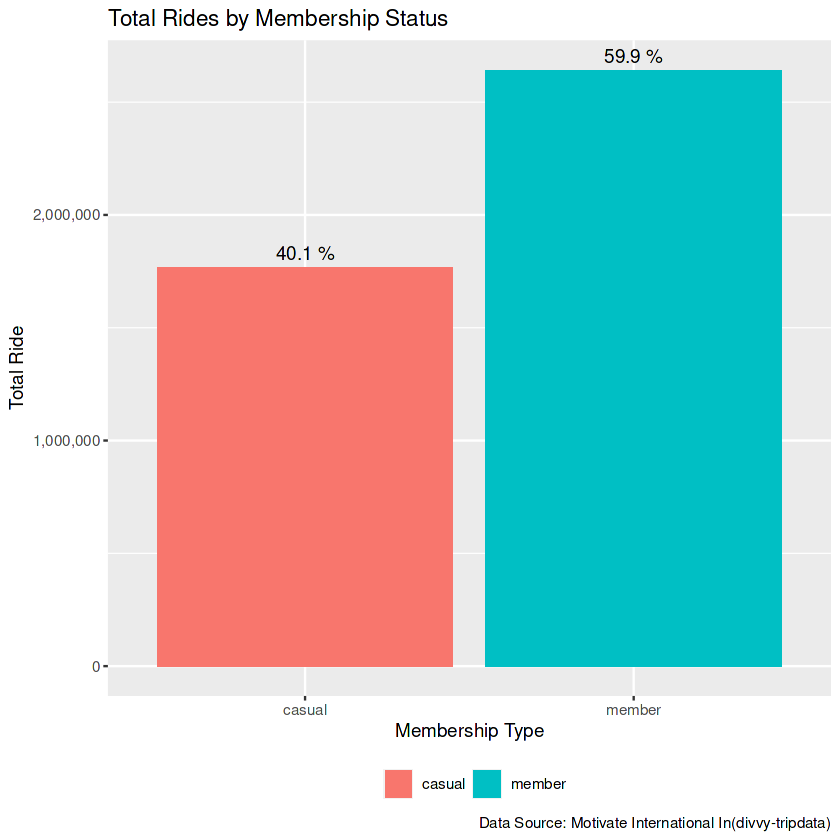

Saving 12.5 x 6.67 in image



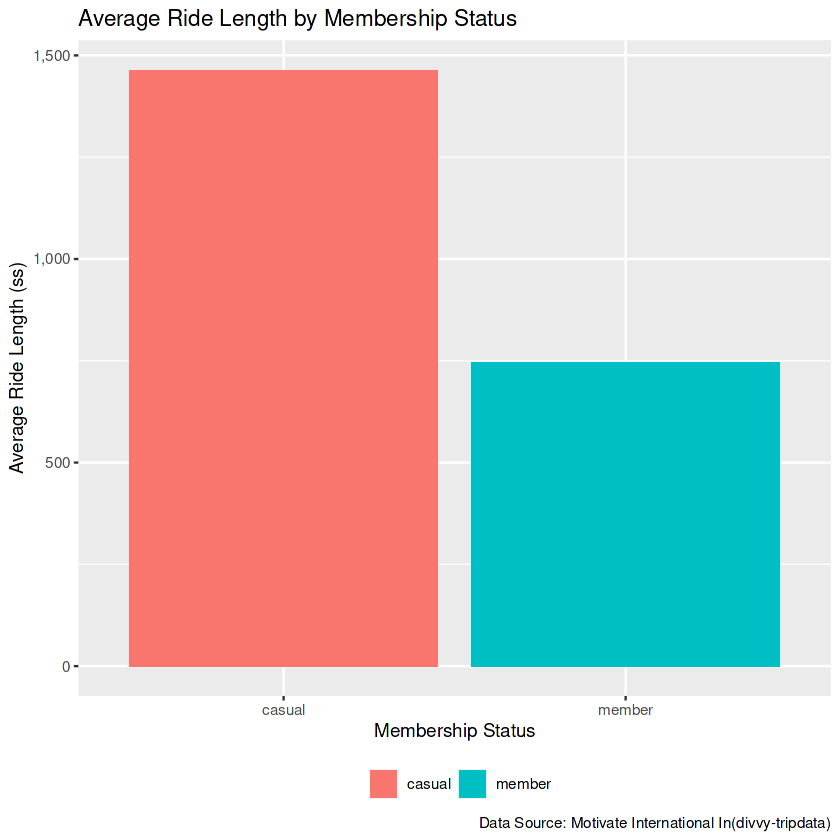

Saving 12.5 x 6.67 in image



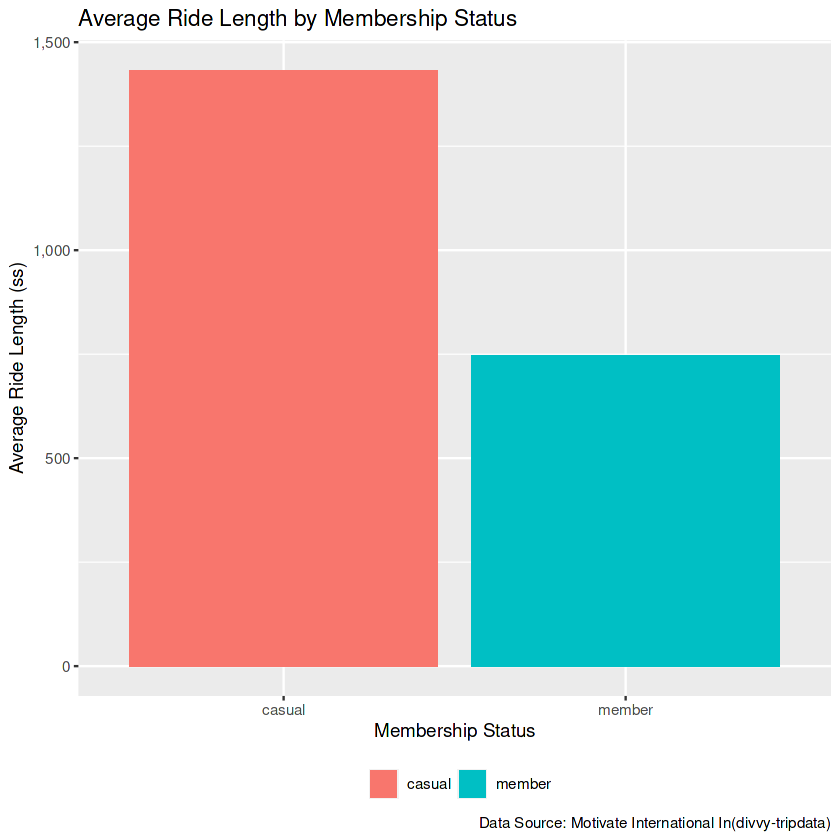

In [5]:
#Total Ride, Average Ride Length by Membership Status
member_type<- data_biketrips %>% 
  group_by(member_casual) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())

member_type
member_type1<- data_biketrips %>%
  filter(ride_length_ss <=84000)%>%
  group_by(member_casual) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())

#Total Rides by Membership Status
ggplot(data=member_type, aes(x=member_casual, y=count, fill=member_casual) )+
  geom_col()+
  geom_text(aes(label = paste(round((count/sum(count))*100,1),"%"), vjust = -.5)) +
  labs(x="Membership Type", y="Total Ride", title="Total Rides by Membership Status",caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())
ggsave("3_total_ride_by_user_type.png")

#Average Ride Length by Membership Status
ggplot(data=member_type, aes(x=member_casual, y=mean, fill=member_casual) )+
  geom_col()+
  labs(x="Membership Status", y="Average Ride Length (ss)", title="Average Ride Length by Membership Status",caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())
ggsave("3_rides_length_by_user_type.png")

#Average Ride Length by Membership Status - ride_length is Less than a day
ggplot(data=member_type1, aes(x=member_casual, y=mean, fill=member_casual) )+
  geom_col()+
  labs(x="Membership Status", y="Average Ride Length (ss)", title="Average Ride Length by Membership Status", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())
ggsave("3_rides_length_by_user_type_removeover1day.png")

Insight 3 - In the last tweleve years, the Number of member user types is higher than the casual users.

Insight-4 - In terms of Average ride length, casual users intend to use bikes for longer time compared to member users

`summarise()` has grouped output by 'day_of_week'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'day_of_week'. You can override using the
`.groups` argument.
Saving 12.5 x 6.67 in image



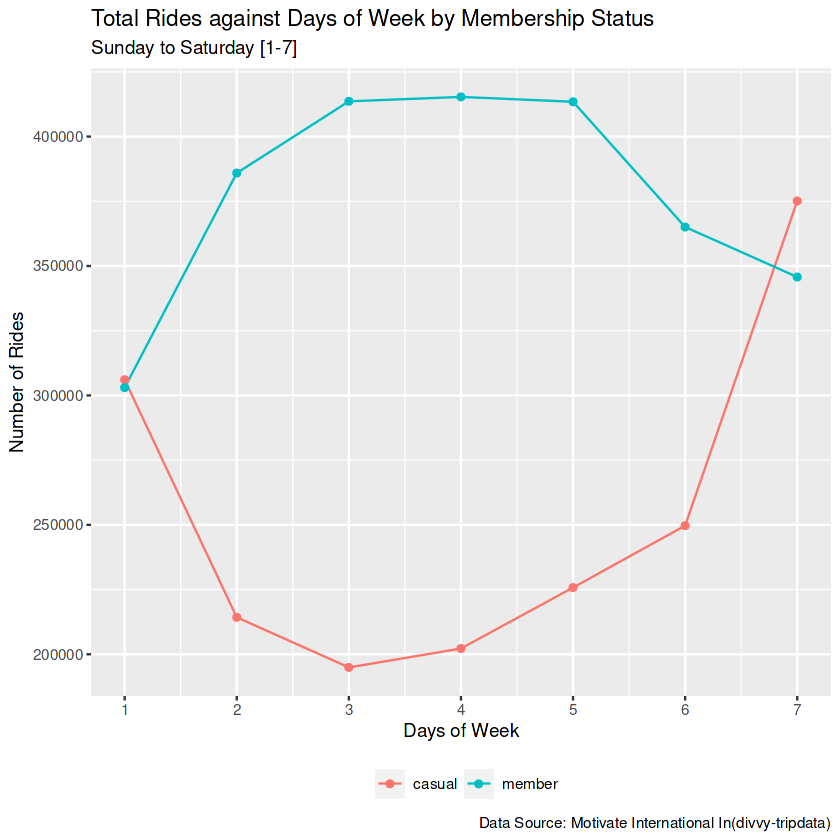

Saving 12.5 x 6.67 in image



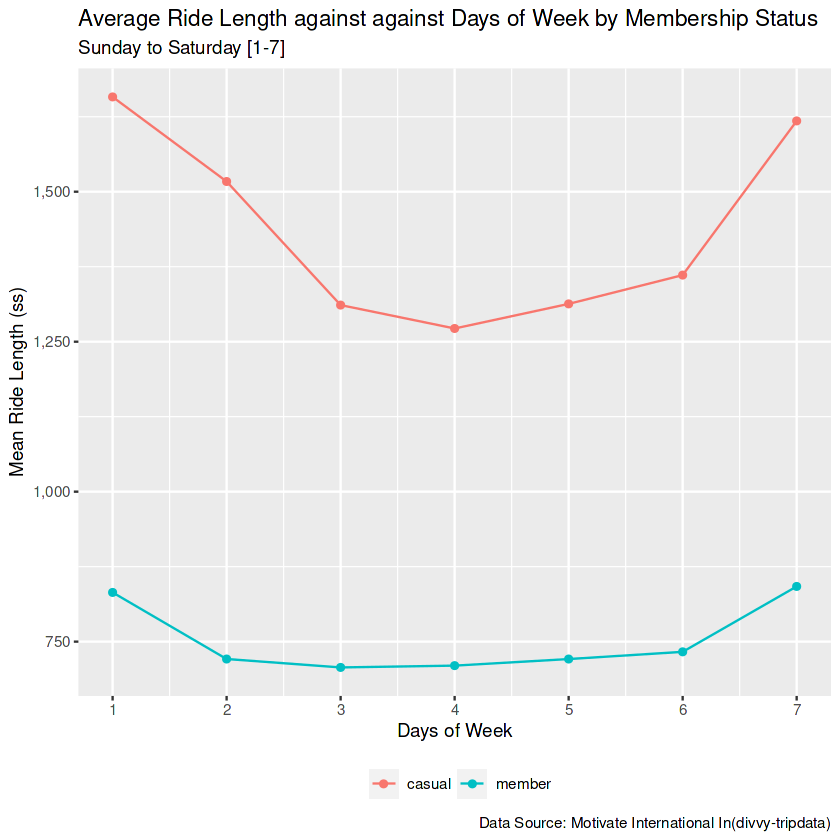

Saving 12.5 x 6.67 in image



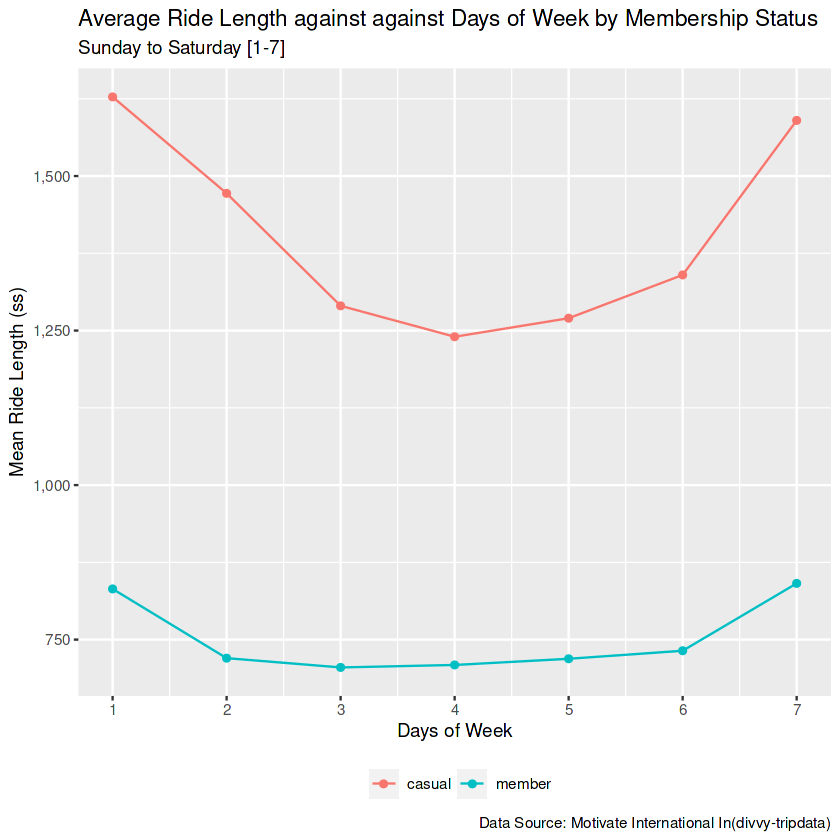

In [6]:
#----------- Total Rides and Average Ride Length against Days of Week by membership Status
cyclist_type_by_day<- data_biketrips %>% 
  group_by(day_of_week, member_casual) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())

cyclist_type_by_day1<- data_biketrips %>% 
  filter(ride_length_ss <=84000)%>%
  group_by(day_of_week, member_casual) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())

#Total Rides against Days of Week by Membership Status
ggplot(data=cyclist_type_by_day, aes(x=day_of_week, y=count, group=member_casual, color=member_casual) )+
  geom_line()+
  geom_point()+
  #facet_wrap(~member_casual)+
  labs(x="Days of Week", y="Number of Rides", title="Total Rides against Days of Week by Membership Status", subtitle = "Sunday to Saturday [1-7]", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_x_continuous(breaks=c(1:7), labels=c(1:7),limits=c(1,7))+
  theme(legend.position="bottom", legend.title = element_blank())
ggsave("4_rides_days_of_week_usertypes.png")


#Average Ride Length against against Days of Week by Membership Status

ggplot(data=cyclist_type_by_day, aes(x=day_of_week, y=mean, group=member_casual, color=member_casual) )+
  geom_line()+
  geom_point()+
  #facet_wrap(~member_casual)+
  labs(x="Days of Week", y="Mean Ride Length (ss)", title="Average Ride Length against against Days of Week by Membership Status", subtitle = "Sunday to Saturday [1-7]", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_x_continuous(breaks=c(1:7), labels=c(1:7),limits=c(1,7))+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())
ggsave("5_average_ridelength_days_of_week_usertypes.png")

ggplot(data=cyclist_type_by_day1, aes(x=day_of_week, y=mean, group=member_casual, color=member_casual) )+
  geom_line()+
  geom_point()+
  #facet_wrap(~member_casual)+
  labs(x="Days of Week", y="Mean Ride Length (ss)", title="Average Ride Length against against Days of Week by Membership Status", subtitle = "Sunday to Saturday [1-7]", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_x_continuous(breaks=c(1:7), labels=c(1:7),limits=c(1,7))+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())
ggsave("5_average_ridelength_days_of_week_usertypes_removeover1day.png")


Insight 5 - Weekly bike riders by days of week and membership status showed that members are using the bikes more than the casual users during week days. However, on Saturday both users are almost equal in number and on Sunday casual users exceeds the member users.

Insight 6- All days, casual users always uses bikes for much longer period of time. The average ride length of members is below 10 minutes during week days and increase a bit during weekends.

Remark: the effect of high ride_length is not much in overall trend however the daily ride length mean of casual users is affected slightly, e.g look both graph on Wednesday (4). 

`summarise()` has grouped output by 'mon_year'. You can override using the
`.groups` argument.
Saving 12.5 x 6.67 in image



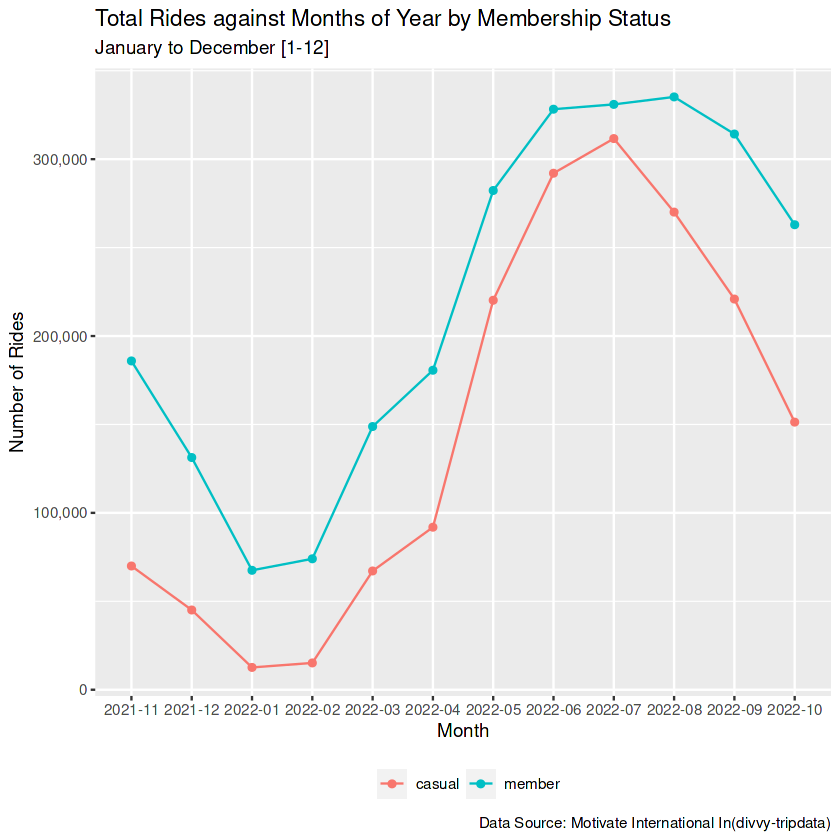

Saving 12.5 x 6.67 in image



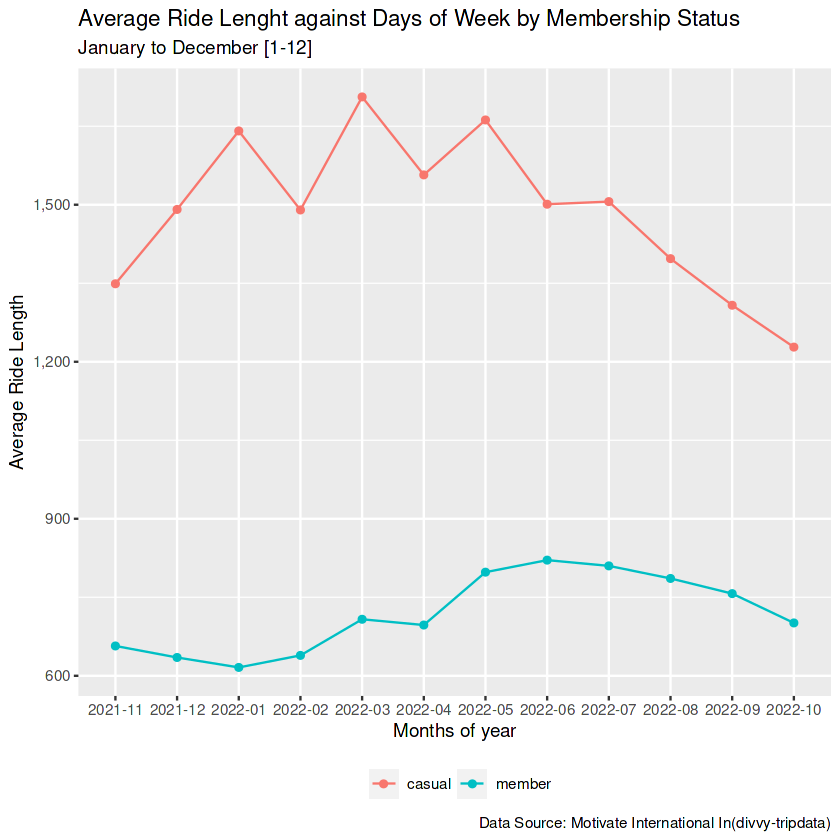

In [7]:
#Number of Rides vs Month of Year
cyclist_type_by_month<- data_biketrips %>% 
  group_by(mon_year, member_casual) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())

#Total Rides against Months of Year by Membership Status
ggplot(data=cyclist_type_by_month, aes(x=mon_year, y=count, group=member_casual, color=member_casual) )+
  geom_line()+
  geom_point()+
  #facet_wrap(~member_casual)+
  labs(x="Month", y="Number of Rides", title="Total Rides against Months of Year by Membership Status", subtitle = "January to December [1-12]",caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())
ggsave("6_rides_by_months_usertype.png")


#Average Ride Lenght against Days of Week by Membership Status
ggplot(data=cyclist_type_by_month, aes(x=mon_year, y=mean, group=member_casual, color=member_casual) )+
  geom_line()+
  geom_point()+
  labs(x="Months of year", y="Average Ride Length", title="Average Ride Lenght against Days of Week by Membership Status", subtitle = "January to December [1-12]",caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())
ggsave("7_average_ride_length_by_months_usertype.png")

Insight 7 - Both members and casual users shows the same trend as discussed in insight . In all cases the number of the members users on the road is higher than the casual users.

Insight 8 - In all the months under investagtion, the average monthly ride length shows casual users always tends to have longer ride than the members.

Saving 12.5 x 6.67 in image



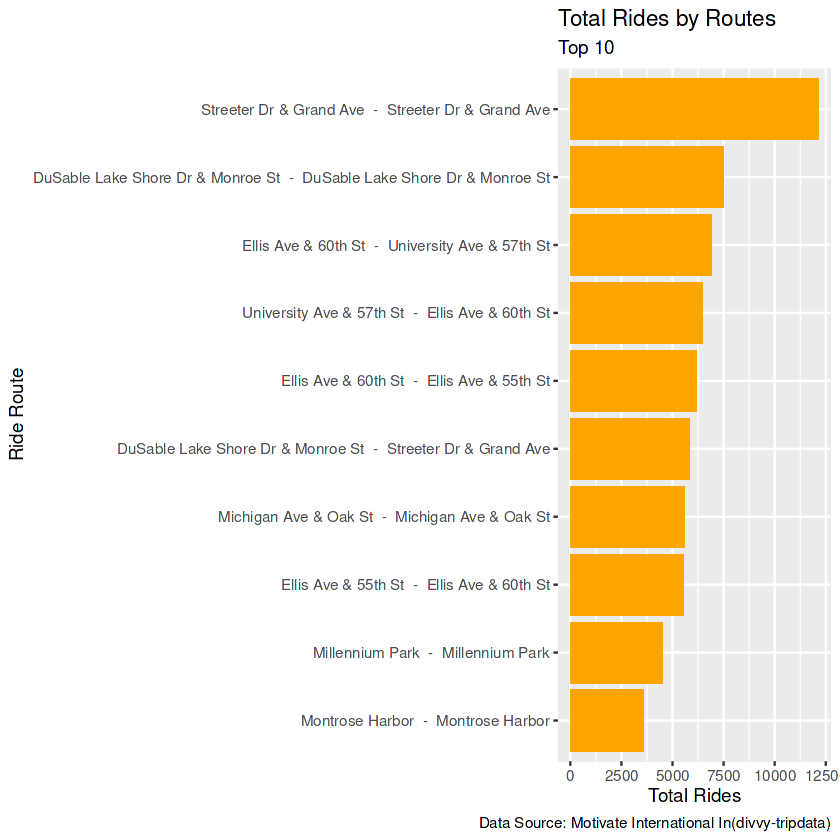

In [8]:
#Top Yearly busy route
buzy_route_high_ride_length<- data_biketrips %>% 
  select(route, ride_length_ss) %>% 
  group_by(route) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())

#remove ride length more than a day
buzy_route_high_ride_length1<- data_biketrips %>%
  filter(ride_length_ss <= 84000)%>%#use only the ride_length less than a day
  select(route, ride_length_ss) %>% 
  group_by(route) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())


Top10_buzy_route <- head(buzy_route_high_ride_length%>%arrange(desc(count)), 10)

ggplot(data=Top10_buzy_route, aes(x=reorder(route, count), y=count), group=1)+
  geom_col(fill="orange")+
  coord_flip()+
  #facet_wrap(~member_casual)+
  labs(x="Ride Route", y="Total Rides", title="Total Rides by Routes", subtitle = "Top 10",caption = "Data Source: Motivate International In(divvy-tripdata)")+
  theme(legend.position="bottom")+
  scale_fill_discrete(name="Membership Type")
ggsave("8_Top10_routes_with_high_no_rides.png")

Insight 9: Combining both user types, the Streeter Dr & Grand Ave and Dusable Lake Shore Dr & Monroe St are the two most busiest station and bike riders rent rides on streets around them. 

`summarise()` has grouped output by 'route'. You can override using the
`.groups` argument.
Saving 12.5 x 6.67 in image



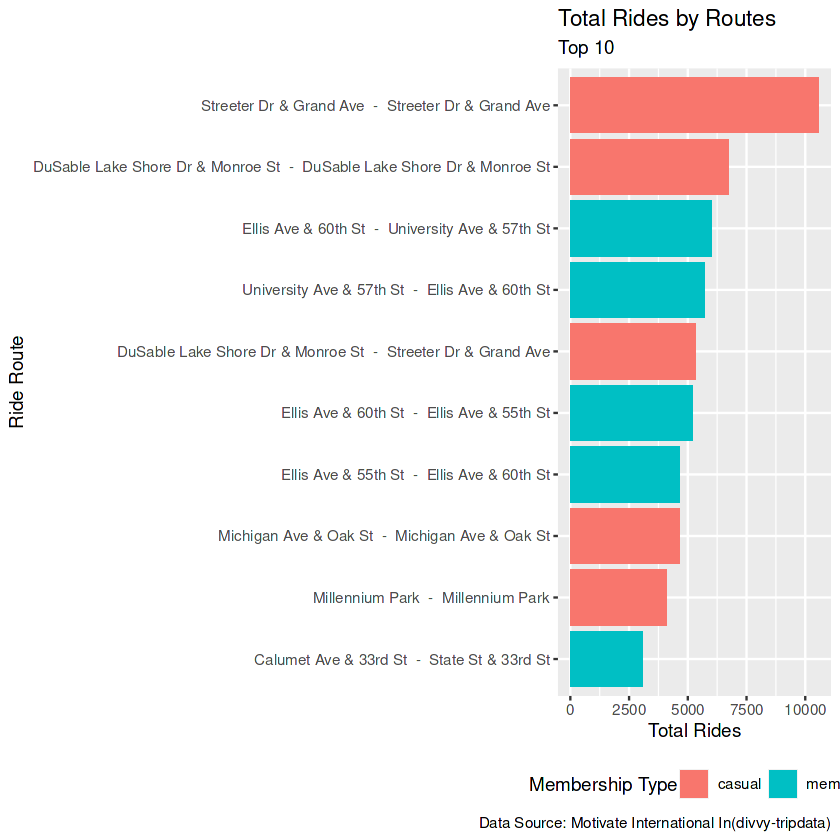

In [9]:
#Buzy routes against user types
route_user_type<- data_biketrips %>% 
  select(route, member_casual, ride_length_ss) %>% 
  group_by(route, member_casual) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())

top10_ridenumbers_route <- head(route_user_type %>%
                                   arrange(desc(count)),10)

ggplot(data=top10_ridenumbers_route, aes(x=reorder(route, count), y=count, fill=member_casual), group=1)+
  geom_col()+
  coord_flip()+
  labs(x="Ride Route", y="Total Rides", title="Total Rides by Routes", subtitle = "Top 10", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  theme(legend.position="bottom")+
  scale_fill_discrete(name="Membership Type")
ggsave("9_Top10_routes_by_usertype.png")

Insight 10 - dissecting the route by user types and total rides doesn't change the previous top 10 rank. This shows a typical user type is using the route for a specific type. Perhaps tourists use the first two routes and the members, e.g students from/to the University & 57th st of avenue to Ellis Ave & 60th st. More casual users are ridig to the Millennium Park. 

Saving 12.5 x 6.67 in image



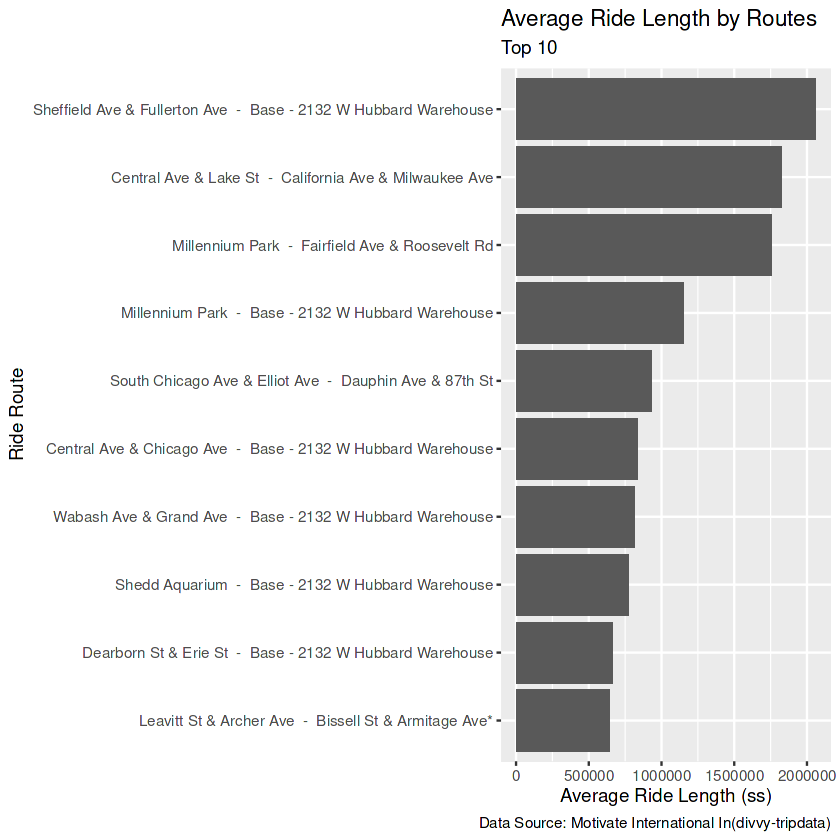

Saving 12.5 x 6.67 in image



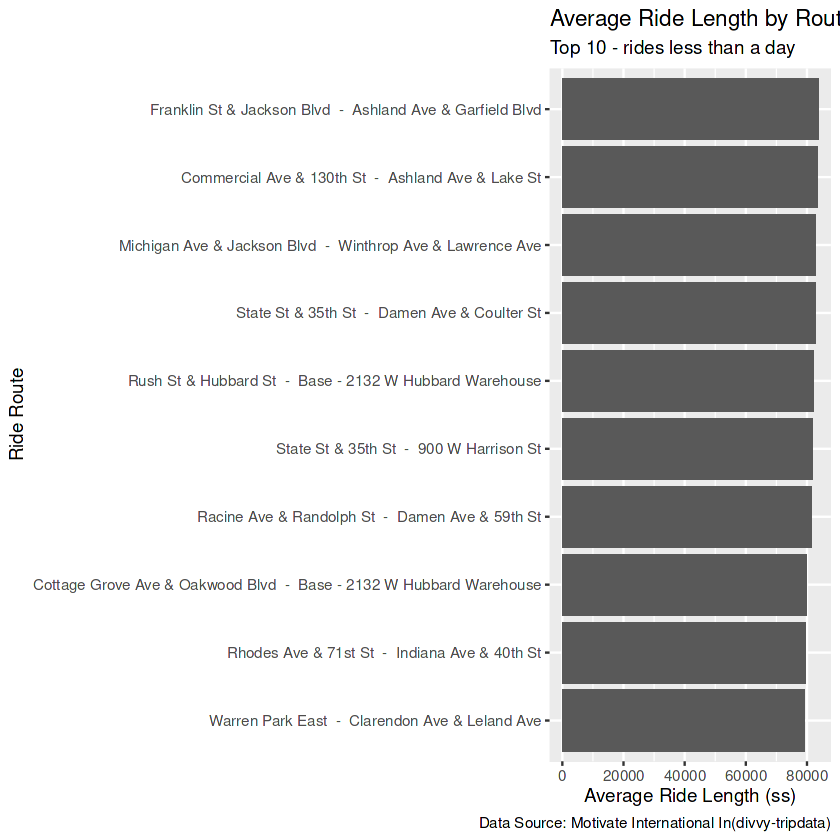

In [10]:
#Routes with average high ride length
top10_rideLength_route <- head(buzy_route_high_ride_length %>%
                                arrange(desc(mean)),10)

#routes with average high ride length - removing all rides more than a day
top10_rideLength_route1 <- head(buzy_route_high_ride_length1 %>%
                                arrange(desc(mean)),10)

#Average Ride Length against Ride Route by Membership Status
ggplot(data=top10_rideLength_route, aes(x=reorder(route, mean), y=mean), group=1 )+
  geom_col()+
  coord_flip()+
  labs(x="Ride Route", y="Average Ride Length (ss)", title="Average Ride Length by Routes", subtitle = "Top 10", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  theme(legend.position="bottom")+
  scale_fill_discrete(name="Membership Type")
ggsave("10_Top10_routes_with_average_ridelength.png")

#Average Ride Length against Ride Route by Membership Status
ggplot(data=top10_rideLength_route1, aes(x=reorder(route, mean), y=mean), group=1 )+
  geom_col()+
  coord_flip()+
  labs(x="Ride Route", y="Average Ride Length (ss)", title="Average Ride Length by Routes", subtitle = "Top 10 - rides less than a day", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  theme(legend.position="bottom")+
  scale_fill_discrete(name="Membership Type")
ggsave("10_Top10_routes_with_average_ridelength_removeover1.png")

As the analysis become more specific, for example by route, the effect of ride length become clear. These is why we need those data with high ride length. The above insights are for situations when we use the data as it is and remove the high rides with more than a day.


`summarise()` has grouped output by 'rideable_type'. You can override using the
`.groups` argument.
Saving 12.5 x 6.67 in image



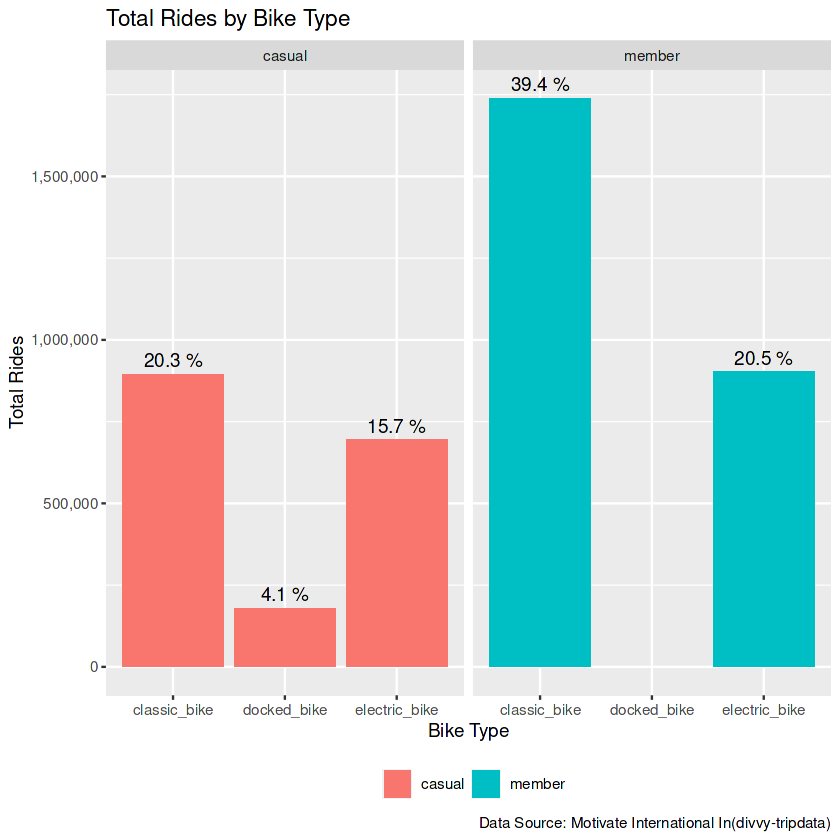

In [11]:
#Riders agains bike type and user types
rideable_type_user_type <- data_biketrips %>%
group_by(rideable_type, member_casual) %>% 
  dplyr::summarise(mean=round(mean(ride_length_ss),0), count=n())

ggplot(data=rideable_type_user_type, aes(x=rideable_type, y=count, fill=member_casual), group=2)+
  geom_col()+
  geom_text(aes(label = paste(round((count/sum(count))*100,1),"%"), vjust = -.5)) +
  labs(x="Bike Type", y="Total Rides", title="Total Rides by Bike Type",  caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())+
  facet_wrap(~member_casual)
ggsave("11_rides_against_bike_type_usertype.png")

Insight: 40% of the total riders are members and rides classic bike . 20% fo the total users are members and rides electric bike.
         20% of the total riders are casual users and rides classic bike. 16% fo the total users are casual and rides electric bike.
         4% of the toal riders are casual and use docked_bike.
         Members don't use docked bike and tends to prefere classic bikes over other types.

Saving 12.5 x 6.67 in image



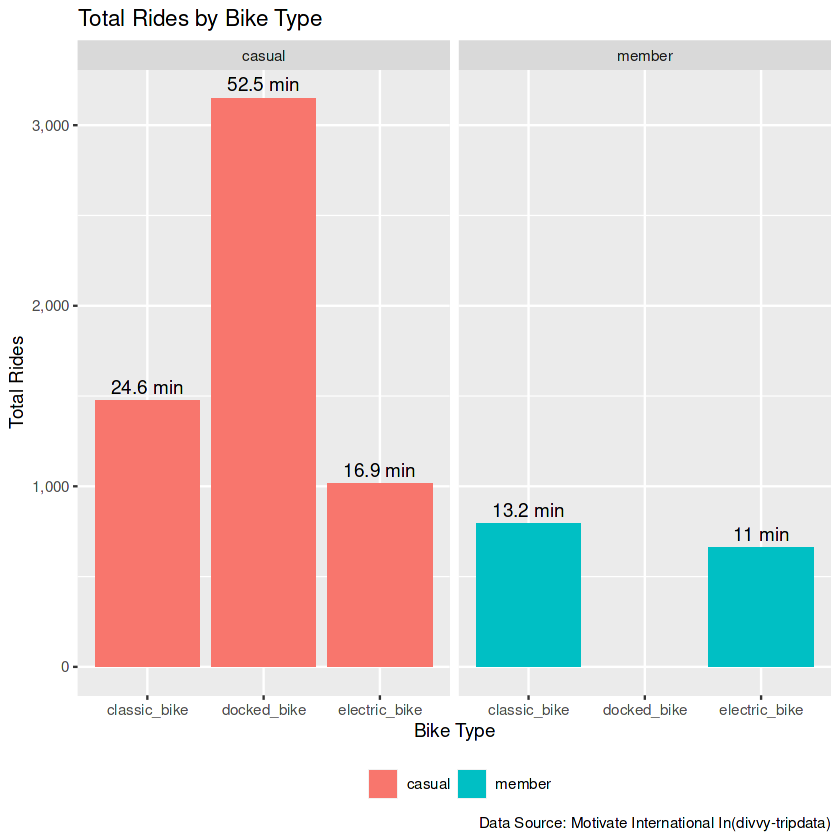

In [12]:
#Average ride lengeth agains bike type and user types

ggplot(data=rideable_type_user_type, aes(x=rideable_type, y=mean, fill=member_casual), group=2)+
  geom_col()+
  geom_text(aes(label = paste(round((mean/60),1),"min"), vjust = -.5)) +
  labs(x="Bike Type", y="Total Rides", title="Total Rides by Bike Type", caption = "Data Source: Motivate International In(divvy-tripdata)")+
  scale_y_continuous(labels = label_comma())+
  theme(legend.position="bottom", legend.title = element_blank())+
  facet_wrap(~member_casual)
ggsave("12_ride_length_bike_type_usertype.png")

Insight - Casual users who use docked bike tends to ride longer than others

#5 - Share

The output graphs saved in working directory is download to the local machine. A presentation file is created using Google Slide Share and shared to users.

Link to Presentation File: https://docs.google.com/presentation/d/e/2PACX-1vSt2r2KW2xalVdchBD38UTgDNWtBJJPSLtDwDThHrjtkuVf9joBx-7LOegAMl4l8Z-rAbNpg70x55_D/pub?start=false&loop=false&delayms=3000